### price forcasting
This notebook loads data and prepares price prediction workflow.

In [1]:
import pandas as pd
import numpy as py

from google.colab import drive
drive.mount('/content/drive')

# Load CSV file from Google Drive
file_path = '/content/drive/MyDrive/fourth/project/wfp_food_prices_eth.csv'
df = pd.read_csv(file_path)

# Access a column
print(df.shape)
print(df.columns)

# View first 5 rows
print(df.head(8))

Mounted at /content/drive
(40482, 14)
Index(['date', 'admin1', 'admin2', 'market', 'latitude', 'longitude',
       'category', 'commodity', 'unit', 'priceflag', 'pricetype', 'currency',
       'price', 'usdprice'],
      dtype='object')
         date       admin1                             admin2  \
0       #date   #adm1+name                         #adm2+name   
1  2000-01-15  Addis Ababa                           AA ZONE1   
2  2000-01-15  Addis Ababa                           AA ZONE1   
3  2000-01-15  Addis Ababa                           AA ZONE1   
4  2000-01-15  Addis Ababa                           AA ZONE1   
5  2000-01-15       Amhara  Administrative unit not available   
6  2000-01-15    Dire Dawa                          DIRE DAWA   
7  2000-01-15       Tigray                             MEKELE   

             market   latitude  longitude            category  \
0  #loc+market+name   #geo+lat   #geo+lon          #item+type   
1       Addis Ababa   9.024325  38.749226  cere

In [2]:
import pandas as pd
import numpy as np

# Drop first row, reset index, convert date column to datetime, and cast numeric columns
df = (
    df.drop(0)
      .reset_index(drop=True)
      .assign(date=lambda x: pd.to_datetime(x['date']))
      .astype({'price': float, 'usdprice': float})
)

# Sort by date, drop duplicates, reset index
df = df.sort_values('date').drop_duplicates().reset_index(drop=True)

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Clean commodity column: remove parentheses text and extract variety
df['commodity_base'] = df['commodity'].str.replace(r'\s*\(.*?\)', '', regex=True).str.strip()
df['variety'] = df['commodity'].str.extract(r'\((.*?)\)', expand=False).fillna('')

# Check missing values
print(df.isnull().sum())

# Replace unavailable admin2 values with NaN
df['admin2'] = df['admin2'].replace('Administrative unit not available', np.nan)

# Convert latitude and longitude to numeric
df[['latitude', 'longitude']] = df[['latitude', 'longitude']].apply(pd.to_numeric, errors='coerce')

# Keep only rows with positive price
df = df[df['price'] > 0].reset_index(drop=True)

# Convert categorical columns
df[['admin1', 'admin2', 'market', 'pricetype', 'category']] = df[['admin1', 'admin2', 'market', 'pricetype', 'category']].astype('category')

# Handle missing admin2 values
df['admin2'] = df['admin2'].cat.add_categories('Unknown').fillna('Unknown')

# Drop rows with missing admin1, latitude, longitude
df = df.dropna(subset=['admin1', 'latitude', 'longitude']).reset_index(drop=True)

# Replace empty variety with 'Standard'
df['variety'] = df['variety'].replace('', 'Standard').fillna('Standard')

# Clean unit column
df['unit'] = df['unit'].str.strip().str.upper()

# Drop unnecessary columns
df = df.drop(columns=['commodity','priceflag','currency'])

# Final checks
print(df.shape)
print(df.tail())
print(df.head())
print(df.info())

date              0
admin1            5
admin2            5
market            0
latitude          5
longitude         5
category          0
commodity         0
unit              0
priceflag         0
pricetype         0
currency          0
price             0
usdprice          0
year              0
month             0
commodity_base    0
variety           0
dtype: int64
(40476, 15)
            date   admin1  admin2             market  latitude  longitude  \
40471 2023-12-15  Gambela  ZONE 3  Kowerneng/Korgang  8.326659  33.953408   
40472 2023-12-15  Gambela  ZONE 2             Punido  7.749505  34.426848   
40473 2023-12-15  Gambela  ZONE 2             Punido  7.749505  34.426848   
40474 2023-12-15  Gambela  ZONE 2             Punido  7.749505  34.426848   
40475 2023-12-15   Somali    GODE               Gode  6.022500  43.130278   

                  category    unit pricetype    price  usdprice  year  month  \
40471   cereals and tubers  100 KG    Retail   4500.0   80.7609  2023   

Outliers detected: 298


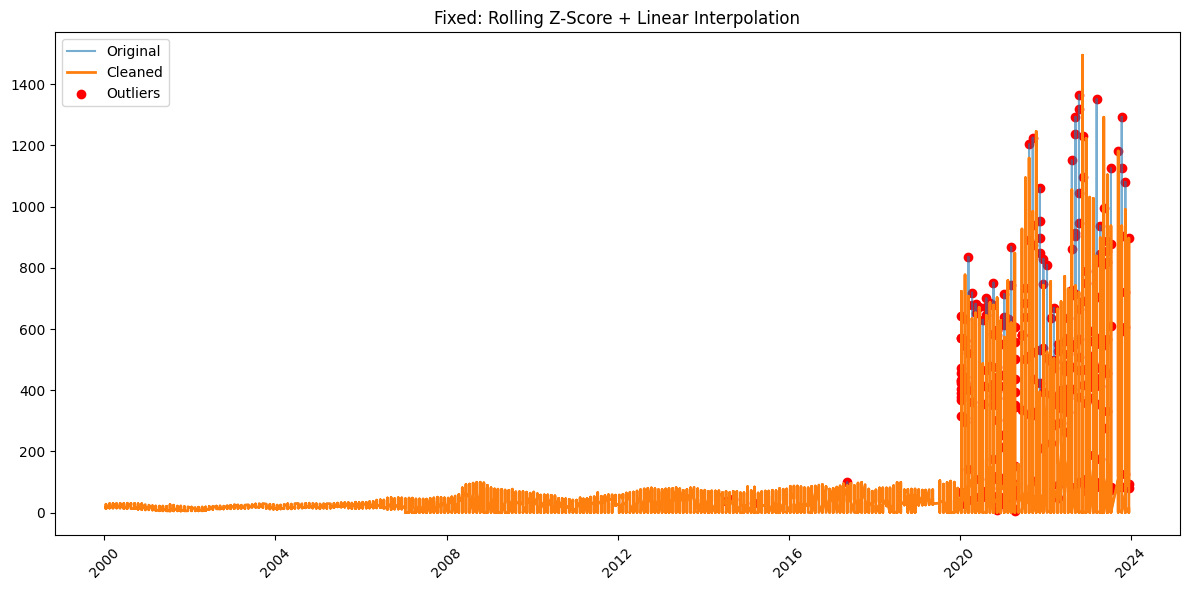

In [3]:
# ============================================================
# FIXED: Rolling Z-Score + Linear Interpolation (NO NaNs, NO outliers)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = df.sort_values('date').reset_index(drop=True)

window = 12
z_threshold = 3

# Rolling stats (min_periods=1 to reduce NaNs)
df['rolling_mean'] = df['usdprice'].rolling(window, min_periods=1).mean()
df['rolling_std']  = df['usdprice'].rolling(window, min_periods=2).std()

df['z_score'] = (df['usdprice'] - df['rolling_mean']) / df['rolling_std']
df['z_score'] = df['z_score'].fillna(0)          # safe for first row

# Detect
df['is_outlier'] = df['z_score'].abs() > z_threshold
print("Outliers detected:", df['is_outlier'].sum())

# FIX: Linear interpolation (recommended)
df['usdprice_cleaned'] = df['usdprice'].mask(df['is_outlier'], np.nan)
df['usdprice_cleaned'] = df['usdprice_cleaned'].interpolate(method='linear')

# Optional: drop helper columns later if not needed as features
# df = df.drop(['rolling_mean','rolling_std','z_score','is_outlier'], axis=1)

# Visualize
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['usdprice'], label='Original', alpha=0.6)
plt.plot(df['date'], df['usdprice_cleaned'], label='Cleaned', linewidth=2)
plt.scatter(df.loc[df['is_outlier'], 'date'], df.loc[df['is_outlier'], 'usdprice'], color='red', label='Outliers')
plt.legend()
plt.title("Fixed: Rolling Z-Score + Linear Interpolation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
# inplace
df.drop(['is_outlier','rolling_std'], axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40476 entries, 0 to 40475
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              40476 non-null  datetime64[ns]
 1   admin1            40476 non-null  category      
 2   admin2            40476 non-null  category      
 3   market            40476 non-null  category      
 4   latitude          40476 non-null  float64       
 5   longitude         40476 non-null  float64       
 6   category          40476 non-null  category      
 7   unit              40476 non-null  object        
 8   pricetype         40476 non-null  category      
 9   price             40476 non-null  float64       
 10  usdprice          40476 non-null  float64       
 11  year              40476 non-null  int32         
 12  month             40476 non-null  int32         
 13  commodity_base    40476 non-null  object        
 14  variety           4047

In [7]:
! pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.0 MB/s eta 0:00:00


In [ ]:
# ============================================================
# 🔥 ADVANCED MULTI-MODEL GLOBAL PRICE FORECASTING
# Commodity + Region | Time Split | Model Comparison
# Hyperparameter Optimization | 6-Month Forecast
# ============================================================

import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt

# Optional Models
try:
    from xgboost import XGBRegressor
    xgb_available = True
except:
    xgb_available = False

try:
    from lightgbm import LGBMRegressor
    lgb_available = True
except:
    lgb_available = False

# ============================================================
# 1️⃣ SORT & CLEAN
# ============================================================
df = df.sort_values("date").reset_index(drop=True)
df.columns = [re.sub('[^A-Za-z0-9_]+', '_', col) for col in df.columns]

# ============================================================
# 2️⃣ CATEGORICAL COLUMNS
# ============================================================
cat_cols = ['admin1','admin2','market',
            'commodity_base','variety',
            'unit','pricetype']

# LightGBM uses category dtype
for col in cat_cols:
    df[col] = df[col].astype("category")

# ============================================================
# 3️⃣ TIME FEATURES
# ============================================================
df['month_sin'] = np.sin(2*np.pi*df['month']/12)
df['month_cos'] = np.cos(2*np.pi*df['month']/12)
df['year_trend'] = df['year'] - df['year'].min()
df['quarter'] = df['date'].dt.quarter

# ============================================================
# 4️⃣ LAG FEATURES (Global Model)
# ============================================================
group_cols = ['commodity_base','admin1']

df['lag_1']  = df.groupby(group_cols)['usdprice_cleaned'].shift(1)
df['lag_3']  = df.groupby(group_cols)['usdprice_cleaned'].shift(3)
df['lag_6']  = df.groupby(group_cols)['usdprice_cleaned'].shift(6)
df['lag_12'] = df.groupby(group_cols)['usdprice_cleaned'].shift(12)

df['roll_mean_3'] = df.groupby(group_cols)['usdprice_cleaned'].transform(lambda x: x.rolling(3).mean())
df['roll_std_3']  = df.groupby(group_cols)['usdprice_cleaned'].transform(lambda x: x.rolling(3).std())

df_model = df.dropna().reset_index(drop=True)

# ============================================================
# 5️⃣ FEATURES
# ============================================================
features = [
    'admin1','admin2','market',
    'latitude','longitude',
    'commodity_base','variety','unit','pricetype',
    'month_sin','month_cos','quarter','year_trend',
    'lag_1','lag_3','lag_6','lag_12',
    'roll_mean_3','roll_std_3'
]

X = df_model[features]
y = df_model['usdprice_cleaned']

# ============================================================
# 6️⃣ TIME SPLIT
# ============================================================
split = int(len(df_model)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# ============================================================
# 7️⃣ TARGET ENCODING FOR NON-LGB MODELS
# ============================================================
te = TargetEncoder(cols=cat_cols)
X_train_te = te.fit_transform(X_train.copy(), y_train)
X_test_te  = te.transform(X_test.copy())

# ============================================================
# 8️⃣ DEFINE MODELS
# ============================================================
models = {}

models["Linear Regression"] = LinearRegression()
models["Random Forest"] = RandomForestRegressor(n_estimators=400, random_state=42)
models["Gradient Boosting"] = GradientBoostingRegressor()

if xgb_available:
    models["XGBoost"] = XGBRegressor(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

if lgb_available:
    models["LightGBM"] = LGBMRegressor(
        n_estimators=500,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

# ============================================================
# 9️⃣ TRAIN & COMPARE
# ============================================================
results = {}
predictions = {}

for name, model in models.items():

    if name == "LightGBM":
        model.fit(X_train, y_train, categorical_feature=cat_cols)
        preds = model.predict(X_test)
    else:
        model.fit(X_train_te, y_train)
        preds = model.predict(X_test_te)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    results[name] = mae
    predictions[name] = preds

    print(f"\n{name}")
    print("MAE :", round(mae,2))
    print("RMSE:", round(rmse,2))

# ============================================================
# 🔟 BEST MODEL
# ============================================================
best_name = min(results, key=results.get)
best_model = models[best_name]

print("\n🏆 BEST MODEL:", best_name)

# ============================================================
# 1️⃣1️⃣ WEIGHTED ENSEMBLE
# ============================================================
total_inv_error = sum(1/v for v in results.values())
weights = {name:(1/results[name])/total_inv_error for name in results}

ensemble_pred = np.zeros(len(X_test))
for name in models:
    ensemble_pred += weights[name] * predictions[name]

ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))

print("\n🔥 Weighted Ensemble")
print("MAE :", round(ensemble_mae,2))
print("RMSE:", round(ensemble_rmse,2))

# ============================================================
# 1️⃣2️⃣ DIRECT MULTI-STEP 6-MONTH FORECAST
# ============================================================
HORIZON = 6
last_obs = df.iloc[-1:].copy()
future_forecasts = []

for h in range(1,HORIZON+1):
    temp = last_obs.copy()
    temp['month_sin'] = np.sin(2*np.pi*((temp['date'].dt.month+h-1)%12+1)/12)
    temp['month_cos'] = np.cos(2*np.pi*((temp['date'].dt.month+h-1)%12+1)/12)
    temp['year_trend'] = temp['year_trend'] + ((temp['date'].dt.month+h-1)//12)

    X_future = temp[features]
    X_future_te = te.transform(X_future.copy())

    pred = 0
    for name, model in models.items():
        if name=="LightGBM":
            p = model.predict(X_future)[0]
        else:
            p = model.predict(X_future_te)[0]
        pred += weights[name]*p

    future_forecasts.append(pred)

print("\n📈 6-Month Forecast (Weighted Ensemble):")
for i,val in enumerate(future_forecasts,1):
    print(f"Month +{i}: {round(val,2)}")

# ============================================================
# 1️⃣3️⃣ VISUALIZATION
# ============================================================
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label="Actual")
plt.plot(ensemble_pred[:200], label="Weighted Ensemble")
plt.title("Weighted Ensemble Predictions vs Actual")
plt.legend()
plt.show()

print("\n✅ Multi-Model Global Forecast Complete")


Linear Regression
MAE : 25.39
RMSE: 54.22


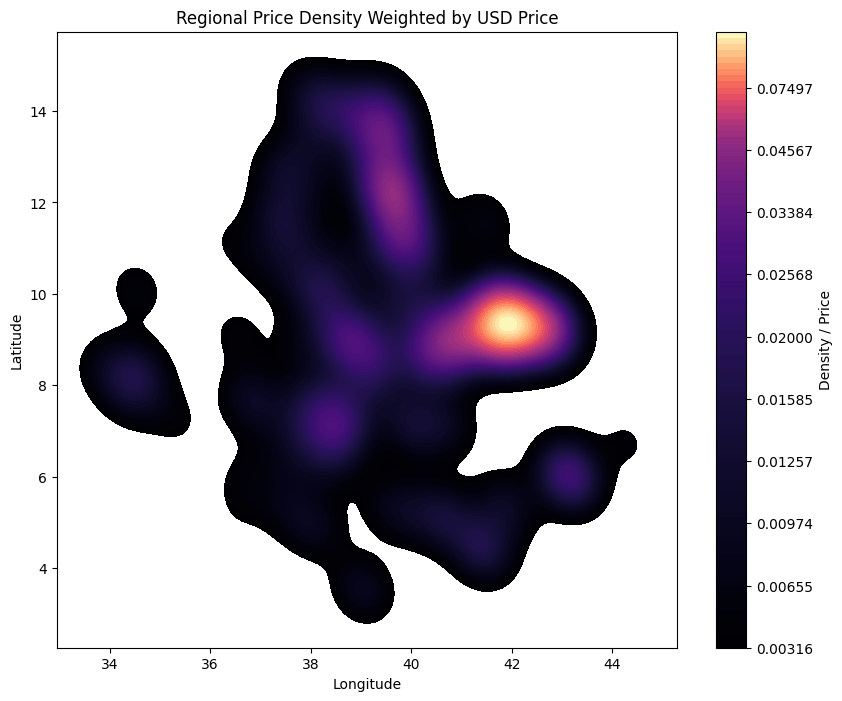

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,8))
sns.kdeplot(
    x=df['longitude'],
    y=df['latitude'],
    weights=df['usdprice'],   # weight by price
    fill=True,
    cmap="magma",
    thresh=0.05,
    levels=100,
    cbar=True, # Added cbar=True to let kdeplot draw its own colorbar
    cbar_kws={'label': 'Density / Price'}
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Regional Price Density Weighted by USD Price")
plt.show()

In [ ]:
# ============================================================
# 🔹 SPATIAL DASHBOARD WITH Z-SCORE BASED RISK LEVELS
# ============================================================

import folium
from folium.plugins import MarkerCluster, FeatureGroupSubGroup
import branca.colormap as cm
import numpy as np
import pandas as pd

# -----------------------------
# Use df_model (cleaned dataset used for modeling)
# -----------------------------
dashboard_df = df_model.copy()

# -----------------------------
# 1️⃣ Predict ensemble on full dataset
# -----------------------------
# Transform categorical columns for non-LightGBM models
X_full_te = te.transform(dashboard_df[features])

ensemble_full = np.zeros(len(dashboard_df))
for name, model in models.items():
    if name == "LightGBM":
        ensemble_full += weights[name] * model.predict(dashboard_df[features])
    else:
        ensemble_full += weights[name] * model.predict(X_full_te)

dashboard_df['predicted_price'] = ensemble_full

# -----------------------------
# 2️⃣ Compute z-scores for predicted prices
# -----------------------------
mean_price = dashboard_df['predicted_price'].mean()
std_price  = dashboard_df['predicted_price'].std()
dashboard_df['risk_score'] = (dashboard_df['predicted_price'] - mean_price) / std_price

# -----------------------------
# 3️⃣ Define z-score based risk levels
# -----------------------------
# Typically: Low (< -0.5), Medium (-0.5 to 0.5), High (> 0.5)
dashboard_df['risk_level'] = pd.cut(
    dashboard_df['risk_score'],
    bins=[-np.inf, -0.5, 0.5, np.inf],
    labels=['Low','Medium','High']
)

# -----------------------------
# 4️⃣ Create map
# -----------------------------
m = folium.Map(
    location=[dashboard_df['latitude'].mean(), dashboard_df['longitude'].mean()],
    zoom_start=6,
    tiles='CartoDB positron',
    control_scale=True
)

# Marker cluster
marker_cluster = MarkerCluster(name='All Markets').add_to(m)

# Subgroups per commodity
commodity_groups = {}
for comm in dashboard_df['commodity_base'].unique():
    fg = FeatureGroupSubGroup(marker_cluster, name=str(comm))
    commodity_groups[comm] = fg
    m.add_child(fg)

# -----------------------------
# 5️⃣ Map colors for z-score risk levels
# -----------------------------
risk_colors = {
    'Low':'green',
    'Medium':'orange',
    'High':'red'
}

def get_risk_color(level):
    return risk_colors.get(level, 'gray')

# -----------------------------
# 6️⃣ Add markers to map
# -----------------------------
for _, row in dashboard_df.iterrows():
    color = get_risk_color(row['risk_level'])
    popup_content = f"""
    <div style="font-size:12px; line-height:1.4;">
        <b>Commodity:</b> {row['commodity_base']} ({row['variety']})<br>
        <b>Market:</b> {row['market']}<br>
        <b>Region:</b> {row['admin1']} / {row['admin2']}<br>
        <b>Actual Price:</b> ${row['usdprice']:.2f}<br>
        <b>Predicted Price:</b> ${row['predicted_price']:.2f}<br>
        <b>Risk Score (z-score):</b> {row['risk_score']:.3f}<br>
        <b>Risk Level:</b> {row['risk_level']}
    </div>
    """
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=min(3 + row['usdprice']/5, 15),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        tooltip=f"{row['commodity_base']} - ${row['usdprice']:.2f}",
        popup=folium.Popup(popup_content, max_width=300)
    ).add_to(commodity_groups[row['commodity_base']])

# -----------------------------
# 7️⃣ Add legend
# -----------------------------
colormap = cm.StepColormap(
    colors=['green','orange','red'],
    index=[-0.5,0.5,1.5],  # dummy values for legend, aligns with Low/Medium/High
    vmin=dashboard_df['risk_score'].min(),
    vmax=dashboard_df['risk_score'].max(),
    caption='Risk Level (z-score)'
)
colormap.add_to(m)
folium.LayerControl(collapsed=False).add_to(m)

# -----------------------------
# 8️⃣ Display map
# -----------------------------
m

In [ ]:
# ============================================================
# 🔹 SPATIAL DASHBOARD WITH PERCENTILE-BASED RISK SCORES
# ============================================================

import folium
from folium.plugins import MarkerCluster, FeatureGroupSubGroup
import branca.colormap as cm
import numpy as np
import pandas as pd

# -----------------------------
# Use df_model for dashboard
# -----------------------------
dashboard_df = df_model.copy()

# -----------------------------
# Predict ensemble on full cleaned dataset
# -----------------------------
X_model_te = te.transform(dashboard_df[features])
ensemble_full = np.zeros(len(dashboard_df))

for name, model in models.items():
    if name == "LightGBM":
        ensemble_full += weights[name]*model.predict(dashboard_df[features])
    else:
        ensemble_full += weights[name]*model.predict(X_model_te)

dashboard_df['predicted_price'] = ensemble_full

# -----------------------------
# Percentile-based risk score (0-1)
# -----------------------------
dashboard_df['early_warning_score'] = dashboard_df['predicted_price'].rank(pct=True)

# -----------------------------
# Define 3 risk levels based on percentiles
# -----------------------------
dashboard_df['early_warning_level'] = pd.cut(
    dashboard_df['early_warning_score'],
    bins=[0, 0.33, 0.66, 1.0],
    labels=['Low','Moderate','High'],
    include_lowest=True
)

# -----------------------------
# Create base map
# -----------------------------
m = folium.Map(
    location=[dashboard_df['latitude'].mean(), dashboard_df['longitude'].mean()],
    zoom_start=6, tiles='CartoDB positron', control_scale=True
)

# -----------------------------
# Marker cluster
# -----------------------------
marker_cluster = MarkerCluster(name='All Markets').add_to(m)

# -----------------------------
# Create subgroups per commodity
# -----------------------------
commodity_groups = {}
for comm in dashboard_df['commodity_base'].unique():
    fg = FeatureGroupSubGroup(marker_cluster, name=str(comm))
    commodity_groups[comm] = fg
    m.add_child(fg)

# -----------------------------
# Risk bins and colors
# -----------------------------
risk_colors = ['green', 'orange', 'red']  # Low, Moderate, High
risk_bins = [0, 0.33, 0.66, 1.0]

def get_risk_color(score):
    for i, upper in enumerate(risk_bins[1:]):
        if score <= upper:
            return risk_colors[i]
    return risk_colors[-1]

# -----------------------------
# Add markers with popups
# -----------------------------
for _, row in dashboard_df.iterrows():
    color = get_risk_color(row['early_warning_score'])
    popup_content = f"""
    <div style="font-size:12px; line-height:1.4;">
        <b>Commodity:</b> {row['commodity_base']} ({row['variety']})<br>
        <b>Market:</b> {row['market']}<br>
        <b>Region:</b> {row['admin1']} / {row['admin2']}<br>
        <b>Price:</b> ${row['usdprice']:.2f}<br>
        <b>Predicted Price:</b> ${row['predicted_price']:.2f}<br>
        <b>Risk Score:</b> {row['early_warning_score']:.3f}<br>
        <b>Level:</b> {row['early_warning_level']}
    </div>
    """
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=min(3 + row['usdprice']/5, 15),
        color=color, fill=True, fill_color=color, fill_opacity=0.7,
        tooltip=f"{row['commodity_base']} - ${row['usdprice']:.2f}",
        popup=folium.Popup(popup_content, max_width=300)
    ).add_to(commodity_groups[row['commodity_base']])

# -----------------------------
# Add legend
# -----------------------------
colormap = cm.StepColormap(colors=risk_colors, index=risk_bins, vmin=0, vmax=1, caption='Percentile-Based Risk Score')
colormap.add_to(m)
folium.LayerControl(collapsed=False).add_to(m)

# -----------------------------
# Display map
# -----------------------------
m